In [24]:
import numpy as np
from scipy.linalg import eigh
import matplotlib.pyplot as plt
from scipy.linalg import eig_banded, eig, eigh
from scipy.sparse.linalg import eigsh, eigs
from scipy.sparse import diags, lil_matrix, csr_matrix
import time

### 1. Eigenmodes of drums or membranes of different shapes

#### A. (1 point) 
Discretize eq. (6). Formulate a matrix version of the eigenvalue problem, taking the boundary conditions into account. Hint: draw a small example, number the elements and think about which elements are connected and which are not. Draw a figure showing the discretization points and their positions. Show and explain the shape of the matrix for a very small problem, maybe a 4x4 system.

#### Discretization:
For a general $n \times n$ grid, when formulating the matrix equation $Mv = Kv$ to solve the eigenvalue problem for $\nabla^2v = Kv$, we must consider a larger matrix $M$ and a vector $v$ that represents the values of $v(x,y)$ at all interior points, excluding the boundary. We have a square grid where each interior point is connected to its four nearest neighbors (left, right, up, and down), and the boundary conditions ensure $v(x, y) = 0$ at the edge of the grid.

Given a grid of size $n \times n$, we have $(n-2) \times (n-2)$ interior points due to the exclusion of the boundary. The matrix $M$ will therefore be of size $[(n-2)^2 \times (n-2)^2]$ to account for all interior points.

The Laplacian $\nabla^2v$ at an interior point, using a finite difference approximation with uniform grid spacing $\Delta x = \Delta y$, is:

$
\nabla^2 v(x_i, y_j) \approx \frac{v_{i+1,j} + v_{i-1,j} + v_{i,j+1} + v_{i,j-1} - 4v_{i,j}}{\Delta x^2}
$

#### Matrix Formulation:

Each row of matrix $M$ corresponds to an equation derived from the discretization of the Laplacian at an interior point. - The diagonal elements of $M$ will be $-4/\Delta x^2$, reflecting the $-4v_{i,j}$ term.
- The entries immediately adjacent to the main diagonal (to the left and right) are $1/\Delta x^2$, representing interactions between horizontal neighbors. 
- For interactions between vertical neighbors, we skip $(n-2)$ elements from a diagonal element to reach the next row or column in the matrix, filling in $1/\Delta x^2$. 
- All other entries are $0$, indicating no direct interaction between those points under the finite difference approximation of the Laplacian.

The vector $v$ is a linear arrangement of the values at the interior grid points, stacked row by row.

#### Example for a 4x4 matrix:

For a 4x4 grid with fixed boundaries, if we consider only the interior points for $v$, we get a 2x2 grid of points labeled as $v_{1,1}$, $v_{1,2}$, $v_{2,1}$, $v_{2,2}$

Since each point is connected to its immediate neighbors, the matrix $M$ for this simplified case, assuming $\Delta x^2 = 1$ for simplicity, looks like this:

$
M = \begin{bmatrix}
-4 & 1 & 1 & 0 \\
1 & -4 & 0 & 1 \\
1 & 0 & -4 & 1 \\
0 & 1 & 1 & -4
\end{bmatrix}
$

And the vector $v$ of size $n^2$ would be:

$
v = \begin{bmatrix}
v_{1,1} \\
v_{1,2} \\
v_{2,1} \\
v_{2,2}
\end{bmatrix}
$

### B. (3 points) 
Consider the following three shapes. 1. a square with side length L  
2. a rectangle with sides L and 2L  
3. a circle with diameter L  
Solve the eigenvalue problem. Try scipy.linalg.eig(), eigh() or eigs(), (or something else). Which did you use, and why? Plot the eigenvectors v for some of the smallest eigenvalues, for L = 1. Label the plots with their frequencies.

#### Python Methods:

| Method| Description|
|-------------------------------------|-----------------------------------------------------|
| `scipy.linalg.eig()`                | Computes eigenvalues and eigenvectors of a general (possibly non-symmetric) square dense matrix.                                 |
| `scipy.linalg.eigh()`               | Optimized for Hermitian or real symmetric matrices.                                                                              |
| `scipy.sparse.linalg.eigs()`        | Finds a subset of eigenvalues and eigenvectors of large, sparse, non-symmetric matrices.                                         |
| `scipy.sparse.linalg.eigsh()`       | Similar to `eigs()` but optimized for Hermitian or real symmetric sparse matrices.                                               |
| `scipy.linalg.eigh_tridiagonal()`   | Finds eigenvalues and eigenvectors of tridiagonal matrices.                                                                      |
| `scipy.sparse.linalg.lobpcg()`      | An iterative algorithm for finding the largest eigenvalues and corresponding eigenvectors of large sparse symmetric positive definite matrices. |
| `scipy.linalg.eig_banded()`         | Finds eigenvalues and eigenvectors of banded matrices, efficiently using their structure but not specifically leveraging sparsity.|

- **LAPACK** (Linear Algebra PACKage) is widely used for solving linear algebra problems. It's highly optimized for dense matrices and is the backbone for many `scipy.linalg` functions.
  
- **ARPACK** (ARnoldi PACKage) is designed for solving large-scale eigenvalue problems, especially those involving sparse matrices. It's particularly useful for finding a subset of eigenvalues and eigenvectors, and is used by `scipy.sparse.linalg`.

1
2
3
4
1
2
3
4
1
2
3
4


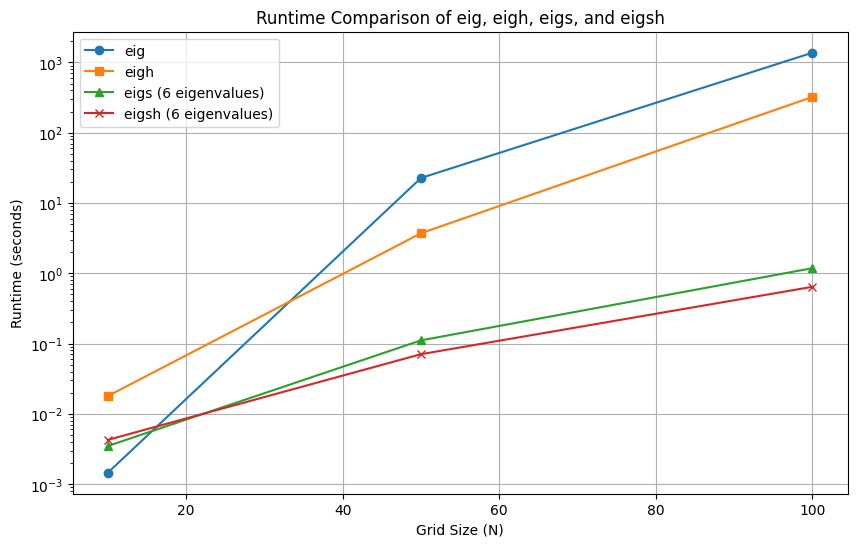

In [27]:
def create_sparse_matrix(N):
    size = (N-2)**2
    diagonals = -4 * np.ones(size)
    off_diags = np.ones(size-1)
    far_off_diags = np.ones(size-(N-2))
    M = diags([diagonals, off_diags, off_diags, far_off_diags, far_off_diags], [0, -1, 1, -(N-2), (N-2)], format="csr")
    return M

grid_sizes = [10, 50, 100]
eig_times, eigh_times, eigs_times, eigsh_times = [], [], [], []

for N in grid_sizes:
    M_sparse = create_sparse_matrix(N)
    M_dense = M_sparse.toarray()

    # eig
    start = time.time()
    eig(M_dense)
    eig_times.append(time.time() - start)
    print("1")
    # eigh
    start = time.time()
    eigh(M_dense)
    eigh_times.append(time.time() - start)
    print("2")

    # eigsh - Computing 6 eigenvalues of smallest magnitude
    start = time.time()
    eigs(M_sparse, k=6, which='SM')
    eigs_times.append(time.time() - start)
    print("3")

    # eigsh - Computing 6 eigenvalues of smallest magnitude
    start = time.time()
    eigsh(M_sparse, k=6, which='SM')
    eigsh_times.append(time.time() - start)
    print("4")

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(grid_sizes, eig_times, marker='o', linestyle='-', label='eig')
plt.plot(grid_sizes, eigh_times, marker='s', linestyle='-', label='eigh')
plt.plot(grid_sizes, eigs_times, marker='^', linestyle='-', label='eigs (6 eigenvalues)')
plt.plot(grid_sizes, eigsh_times, marker='x', linestyle='-', label='eigsh (6 eigenvalues)')
plt.xlabel('Grid Size (N)')
plt.ylabel('Runtime (seconds)')
plt.title('Runtime Comparison of eig, eigh, eigs, and eigsh')
plt.legend()
plt.grid(True)
plt.yscale('log')
plt.show()


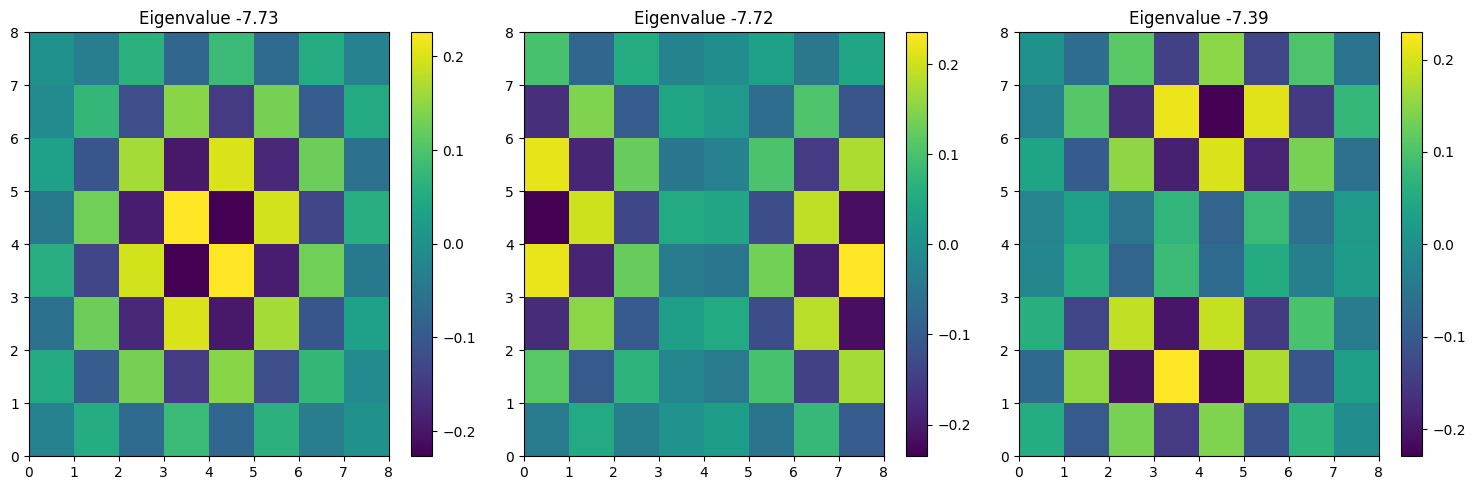

In [29]:
N = 10  # Size of the grid including boundaries
M = create_sparse_matrix(N).toarray()
eigenvalues, eigenvectors = eigh(M)

# Correct the reshape dimensions to match the size of the interior grid
interior_size = N - 2  # Subtracting the boundaries

# Plot the first few eigenvectors
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i in range(3):
    ax = axes[i]
    eigenvector = eigenvectors[:, i].reshape((interior_size, interior_size))
    c = ax.pcolormesh(eigenvector, cmap='viridis')
    fig.colorbar(c, ax=ax)
    ax.set_title(f'Eigenvalue {eigenvalues[i]:.2f}')
plt.tight_layout()
plt.show()
